In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, random, joblib, statistics
import sklearn as sk
import optuna
import xgboost as xgb
import plotly
import textwrap
import json
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm, datasets
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GroupKFold
import functions
import math
from typing import List, Optional, Tuple
from tabulate import tabulate

random.seed(1213870)

## Meta Analysis Plot
meta analysis performance interval = 0.63 - 0.97

In [ ]:
# preparing the data for the meta plot
# Define folder path
folder_path = "./results/test"

# Collect files
files = [
os.path.join(root, file)
for root, _, files in os.walk(folder_path)
for file in files
if '_classification_report' in file
]

# Initialize lists to store results
f1_scores_td = []
f1_scores_asd = []
f1_averages = []
test_names = []
test_types = []

# looping through all models
for file_path in files:

    filename = os.path.basename(file_path)
    name_suffix = filename.find('_participant_classification_report')
    test_name = filename[:name_suffix]
    test_names.append(test_name)
    if "MG" in test_name and "Qfam" in test_name:
        test_type = 'Different Task'
    elif "Qfam" in test_name and "Qunfam" in test_name:
        test_type = 'Different Familiarity'  
    else:
        test_type = 'Within'
    test_types.append(test_type)

    # Load classification report
    classification_report = pd.read_csv(file_path)

    # Extract F1 scores
    f1_td = classification_report.iloc[2, 0]
    f1_asd = classification_report.iloc[2, 1]
    f1_average = classification_report.iloc[2, 4] # changed to weighted average
    f1_scores_td.append(f1_td)
    f1_scores_asd.append(f1_asd)
    f1_averages.append(f1_average)

# Combine results into a DataFrame
results = pd.DataFrame({
    'test_type': test_types,
    'test_name': test_names,
    'F1_score_td': f1_scores_td,
    'F1_score_asd': f1_scores_asd,
    'F1_average': f1_averages
})

# Sort the DataFrame by test_type
results = results.sort_values('test_type')

# diving results into within, task, familiarity and meta:
within = results[results['test_type'] == 'Within']
within = within[['F1_average', 'test_type']]
task = results[results['test_type'] == 'Different Task']
task = task[['F1_average', 'test_type']]
familiarity = results[results['test_type'] == 'Different Familiarity']
familiarity = familiarity[['F1_average', 'test_type']]
meta = [0.63, 0.97]
metas = pd.DataFrame({'F1_average': meta, 'test_type': 'Meta Analysis'})

# Concatenate into one DataFrame
data = pd.concat([metas, within, task, familiarity,])

In [ ]:
# creating the plot
plt.figure(figsize=(8, 4))

# Define a color palette for the categories
palette = sns.color_palette("Set2", n_colors=len(data['test_type'].unique()))

# Plot lines connecting points within each category
for i, category in enumerate(data['test_type'].unique()):
    subset = data[data['test_type'] == category]
    # Plot line for each category
    plt.plot([category] * len(subset), subset['f1_mean'], 'o-', color=palette[i], alpha=0.7, label=category)

# aestheticssss
plt.ylabel("F1 Score", fontsize=12)
plt.ylim(0.4, 1)  # y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Plots per dimension: task plot and familiarity plot

Qfam_Qfam_20
Qfam_Qunfam_20
Qfam_Qunfam_80
Qunfam_Qfam_80
Qunfam_Qfam_20
Qunfam_Qunfam_20


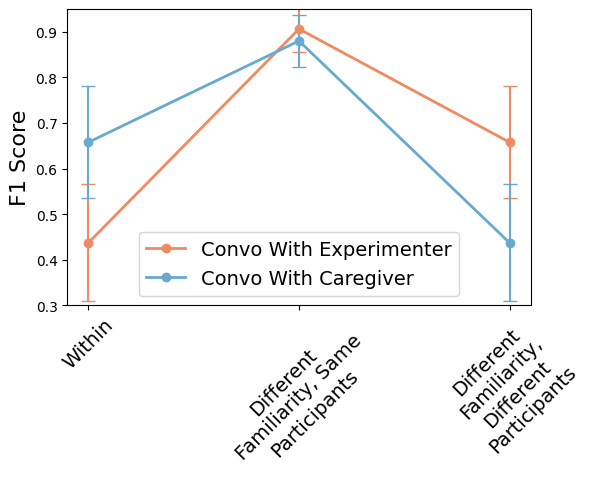

MG_Qfam_20
MG_Qfam_80
MG_MG_20
Qfam_MG_80
Qfam_Qfam_20
Qfam_MG_20


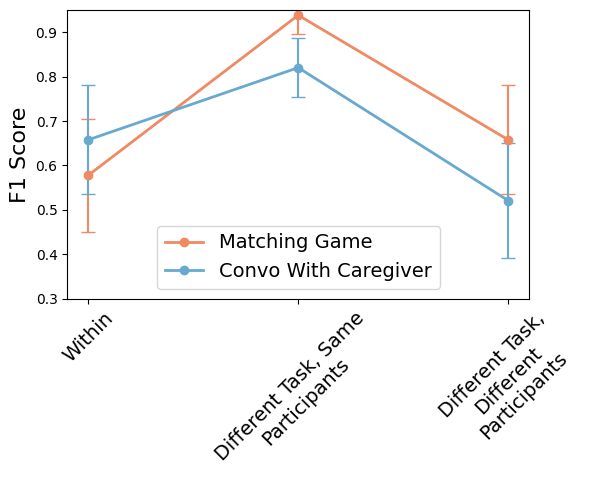

In [2]:
functions.dimension_plot('familiarity')
functions.dimension_plot('task')

## Extracting individual model performance

In [3]:
# MatchingGame
plot_values = functions.class_preparation('MatchingGame', ['MG_MG_20', 'MG_Qfam_80', 'MG_Qfam_20'], new_names = {
    'MG_MG_20': 'Within',
    'MG_Qfam_80': 'Different Task, \nSame Participants',
    'MG_Qfam_20': 'Different Task, \nDifferent Participants'
})
print(tabulate(plot_values, headers='keys', tablefmt='psql'))

functions.class_plot('MatchingGame', plot_values)

AttributeError: 'numpy.float64' object has no attribute 'append'

In [ ]:
# Qfam
plot_values = functions.class_preparation('Qfam', ['Qfam_Qfam_20', 'Qfam_MG_80', 'Qfam_MG_20', 'Qfam_Qunfam_80', 'Qfam_Qunfam_20'], new_names = {
    'Qfam_Qfam_20': 'Within',
    'Qfam_MG_80': 'Different Task, \nSame Participants',
    'Qfam_MG_20': 'Different Task, \nDifferent Participants',
    'Qfam_Qunfam_80': 'Different Familiarity, \nSame Participants',
    'Qfam_Qunfam_20': 'Different Familiarity,\n Different Participants'
    })

print(tabulate(plot_values, headers='keys', tablefmt='psql'))
functions.class_plot('Questions, familiar', plot_values)


In [ ]:
# Qunfam
plot_values = functions.class_preparation('Qunfam', ['Qunfam_Qunfam_20', 'Qunfam_Qfam_80', 'Qunfam_Qfam_20'], new_names = {
    'Qunfam_Qunfam_20': 'Within',
    'Qunfam_Qfam_80': 'Different Familiarity,\n Same Participants',
    'Qunfam_Qfam_20': 'Different Familiarity,\n Different Participants'
})

print(tabulate(plot_values, headers='keys', tablefmt='psql'))
functions.class_plot('Questions, unfamiliar', plot_values)

### Heatmaps

In [ ]:
same = functions.heatmaps_preparation('same')
different = functions.heatmaps_preparation('different')

In [ ]:
# age
functions.heatmaps_plot('age', same)
functions.heatmaps_plot('age', different)

In [ ]:
# sex
functions.heatmaps_plot('sex', same)
functions.heatmaps_plot('sex', different)